In [2]:
!nvidia-smi

Thu Apr 22 15:25:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   35C    P0    64W / 350W |  13790MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM3...  On   | 00000000:36:00.0 Off |                    0 |
| N/A   53C    P0   275W / 350W |  28633MiB / 32480MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [332]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
while Path.cwd().name != 'bayesian_beats_cheats':
    os.chdir(Path.cwd().parent)
    
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
# from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import seaborn as sns
import time
from datetime import datetime

######## TORCH ###########
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch.utils.tensorboard import SummaryWriter


######## Jon's code #########
from src import preprocess
from src.visualization import make_confusion_matrix, parse_results

In [4]:
# GPU = 8,13

# gpu_list = ''
# multi_gpus=False
# if isinstance(GPU, int):
#     gpu_list = str(GPU)
# else:
#     multi_gpus = True
#     for i, gpu_id in enumerate(GPU):
#         gpu_list += str(gpu_id)
#         if i != len(GPU) - 1:
#             gpu_list += ','
#     os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list
#     print(gpu_list)

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

In [5]:
!tensorboard --logdir=runs

^C
Traceback (most recent call last):
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/compat/__init__.py", line 46, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kenghwee/cs5340_proj/env/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/main.py", line 58, in run_main
    if getattr(tf, "__version__", "stub") == "stub":
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/lazy.py", line 68, in __getattr__
    return getattr(load_once(self), attr_name)
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/lazy.py", line 100, in wrap

## Torch Geometric Data Loader

In [315]:
from torch_geometric.data import InMemoryDataset
from sklearn import preprocessing

class BBCDataset_Uniq(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(BBCDataset_Uniq, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir,'data/imputed_unified_node_data.csv'), os.path.join(curr_dir, 'data/uniq_lines_edge_weights.csv')]
    
    @property
    def processed_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir, 'GNN/graph.pt')]
    
    def process(self):
        df_node = pd.read_csv(self.raw_paths[0], keep_default_na=False)
        df_edge = pd.read_csv(self.raw_paths[1])
        
        X_train, X_val, X_test, y_train, y_val, y_test = preprocess.stratified_train_val_test_split(df_node)
        
        # Labels
        y = pd.concat([y_train, y_val, y_test]).sort_index()
        y = y.apply(lambda x: 1 if x>0 else 0)
        
        # Mappings
        id2name = dict(zip(df_node.index, df_node["name"].values))
        name2id = dict(zip(df_node["name"].values, df_node.index))
        
        # Feature pre-processing
        usable_cols = ['year_of_study', 'participation',
                     'pe_percent', 'finals_percent',
                     'midterms_percent', 'afast',
                     'level_min_max', 'exp_min_max',
                     'num_videos', 'avg_videos_completion',
                     'batch_1821', 'batch_1935',
                     'batch_2023', 'major_-',
                     'major_Business Analytics', 'major_Chemistry',
                     'major_Computational Biology', 'major_Data Science and Analytics',
                     'major_Faculty of Arts & Social Sci', 'major_Faculty of Engineering',
                     'major_Faculty of Law', 'major_Faculty of Science',
                     'major_Life Sciences', 'major_Math/Applied Math',
                     'major_NUS Business School', 'major_Pharmacy',
                     'major_Physics', 'major_Quantitative Finance',
                     'major_School of Computing', 'major_School of Design & Environment',
                     'major_Statistics', 'major_Yong Loo Lin School (Medicine)']
        
        df_node = df_node[usable_cols]
        mm_scaler = preprocessing.MinMaxScaler()
        df_node_kh = mm_scaler.fit_transform(df_node)
        
        # Generating masks
        train_mask = df_node.index.isin(X_train.index)
        val_mask = df_node.index.isin(X_val.index)
        test_mask = df_node.index.isin(X_test.index)
        
        # Generating edges
        df_edge["NodeID1_Num"] = df_edge["NodeID1"].map(name2id)
        df_edge["NodeID2_Num"] = df_edge["NodeID2"].map(name2id)
        df_edge_index = df_edge[["NodeID1_Num", "NodeID2_Num"]].values.tolist()
        df_edge_weights = df_edge["edge_weights"].values.tolist()
        reverse_edge_index = [list(reversed(x)) for x in df_edge_index]
        lst = list(zip(df_edge_index + reverse_edge_index, df_edge_weights * 2))
        edge_index, edge_weights = [], []
        for edge, weight in lst:
            edge_index.append(edge)
            edge_weights.append(weight)
            
        # Generating Data API
        final_x = torch.tensor(df_node_kh, dtype=torch.float)
        # final_x = torch.ones(df_node.shape[0], 1)
        final_train_mask = torch.tensor(train_mask, dtype=torch.bool)
        final_val_mask = torch.tensor(val_mask, dtype=torch.bool)
        final_test_mask = torch.tensor(test_mask, dtype=torch.bool)
        final_y = torch.tensor(y.values, dtype=torch.int64)
        final_edge_index = torch.tensor(edge_index, dtype=torch.long)
        final_edge_weights = torch.tensor(edge_weights, dtype=torch.float)
        
        data = Data(x=final_x, train_mask=final_train_mask, val_mask=final_val_mask, 
                    test_mask=final_test_mask, y=final_y, edge_index=final_edge_index.t().contiguous(), 
                    edge_weight=final_edge_weights.t(), num_classes=2)
        
        print(data.__dict__)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])
        
class BBCDataset_Max(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(BBCDataset_Max, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir,'data/imputed_unified_node_data.csv'), os.path.join(curr_dir, 'data/max_edge_weights.csv')]
    
    @property
    def processed_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir, 'GNN/graph_max.pt')]
    
    def process(self):
        df_node = pd.read_csv(self.raw_paths[0], keep_default_na=False)
        df_edge = pd.read_csv(self.raw_paths[1])
        
        X_train, X_val, X_test, y_train, y_val, y_test = preprocess.stratified_train_val_test_split(df_node)
        
        # Labels
        y = pd.concat([y_train, y_val, y_test]).sort_index()
        y = y.apply(lambda x: 1 if x>0 else 0)
        
        # Mappings
        id2name = dict(zip(df_node.index, df_node["name"].values))
        name2id = dict(zip(df_node["name"].values, df_node.index))
        
        # Feature pre-processing
        usable_cols = ['year_of_study', 'participation',
                     'pe_percent', 'finals_percent',
                     'midterms_percent', 'afast',
                     'level_min_max', 'exp_min_max',
                     'num_videos', 'avg_videos_completion',
                     'batch_1821', 'batch_1935',
                     'batch_2023', 'major_-',
                     'major_Business Analytics', 'major_Chemistry',
                     'major_Computational Biology', 'major_Data Science and Analytics',
                     'major_Faculty of Arts & Social Sci', 'major_Faculty of Engineering',
                     'major_Faculty of Law', 'major_Faculty of Science',
                     'major_Life Sciences', 'major_Math/Applied Math',
                     'major_NUS Business School', 'major_Pharmacy',
                     'major_Physics', 'major_Quantitative Finance',
                     'major_School of Computing', 'major_School of Design & Environment',
                     'major_Statistics', 'major_Yong Loo Lin School (Medicine)']
        
        df_node = df_node[usable_cols]
        mm_scaler = preprocessing.MinMaxScaler()
        df_node_kh = mm_scaler.fit_transform(df_node)
        
        # Generating masks
        train_mask = df_node.index.isin(X_train.index)
        val_mask = df_node.index.isin(X_val.index)
        test_mask = df_node.index.isin(X_test.index)
        
        # Generating edges
        df_edge["NodeID1_Num"] = df_edge["NodeID1"].map(name2id)
        df_edge["NodeID2_Num"] = df_edge["NodeID2"].map(name2id)
        df_edge_index = df_edge[["NodeID1_Num", "NodeID2_Num"]].values.tolist()
        df_edge_weights = df_edge["edge_weights"].values.tolist()
        reverse_edge_index = [list(reversed(x)) for x in df_edge_index]
        lst = list(zip(df_edge_index + reverse_edge_index, df_edge_weights * 2))
        edge_index, edge_weights = [], []
        for edge, weight in lst:
            edge_index.append(edge)
            edge_weights.append(weight)
            
        # Generating Data API
        final_x = torch.tensor(df_node_kh, dtype=torch.float)
        # final_x = torch.ones(df_node.shape[0], 1)
        final_train_mask = torch.tensor(train_mask, dtype=torch.bool)
        final_val_mask = torch.tensor(val_mask, dtype=torch.bool)
        final_test_mask = torch.tensor(test_mask, dtype=torch.bool)
        final_y = torch.tensor(y.values, dtype=torch.int64)
        final_edge_index = torch.tensor(edge_index, dtype=torch.long)
        final_edge_weights = torch.tensor(edge_weights, dtype=torch.float)
        
        data = Data(x=final_x, train_mask=final_train_mask, val_mask=final_val_mask, 
                    test_mask=final_test_mask, y=final_y, edge_index=final_edge_index.t().contiguous(), 
                    edge_weight=final_edge_weights.t(), num_classes=2)
        
        print(data.__dict__)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])
        
class BBCDataset_Min(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(BBCDataset_Min, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir,'data/imputed_unified_node_data.csv'), os.path.join(curr_dir, 'data/min_edge_weights.csv')]
    
    @property
    def processed_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir, 'GNN/graph_min.pt')]
    
    def process(self):
        df_node = pd.read_csv(self.raw_paths[0], keep_default_na=False)
        df_edge = pd.read_csv(self.raw_paths[1])
        
        X_train, X_val, X_test, y_train, y_val, y_test = preprocess.stratified_train_val_test_split(df_node)
        
        # Labels
        y = pd.concat([y_train, y_val, y_test]).sort_index()
        y = y.apply(lambda x: 1 if x>0 else 0)
        
        # Mappings
        id2name = dict(zip(df_node.index, df_node["name"].values))
        name2id = dict(zip(df_node["name"].values, df_node.index))
        
        # Feature pre-processing
        usable_cols = ['year_of_study', 'participation',
                     'pe_percent', 'finals_percent',
                     'midterms_percent', 'afast',
                     'level_min_max', 'exp_min_max',
                     'num_videos', 'avg_videos_completion',
                     'batch_1821', 'batch_1935',
                     'batch_2023', 'major_-',
                     'major_Business Analytics', 'major_Chemistry',
                     'major_Computational Biology', 'major_Data Science and Analytics',
                     'major_Faculty of Arts & Social Sci', 'major_Faculty of Engineering',
                     'major_Faculty of Law', 'major_Faculty of Science',
                     'major_Life Sciences', 'major_Math/Applied Math',
                     'major_NUS Business School', 'major_Pharmacy',
                     'major_Physics', 'major_Quantitative Finance',
                     'major_School of Computing', 'major_School of Design & Environment',
                     'major_Statistics', 'major_Yong Loo Lin School (Medicine)']
        
        df_node = df_node[usable_cols]
        mm_scaler = preprocessing.MinMaxScaler()
        df_node_kh = mm_scaler.fit_transform(df_node)
        
        # Generating masks
        train_mask = df_node.index.isin(X_train.index)
        val_mask = df_node.index.isin(X_val.index)
        test_mask = df_node.index.isin(X_test.index)
        
        # Generating edges
        df_edge["NodeID1_Num"] = df_edge["NodeID1"].map(name2id)
        df_edge["NodeID2_Num"] = df_edge["NodeID2"].map(name2id)
        df_edge_index = df_edge[["NodeID1_Num", "NodeID2_Num"]].values.tolist()
        df_edge_weights = df_edge["edge_weights"].values.tolist()
        reverse_edge_index = [list(reversed(x)) for x in df_edge_index]
        lst = list(zip(df_edge_index + reverse_edge_index, df_edge_weights * 2))
        edge_index, edge_weights = [], []
        for edge, weight in lst:
            edge_index.append(edge)
            edge_weights.append(weight)
            
        # Generating Data API
        final_x = torch.tensor(df_node_kh, dtype=torch.float)
        # final_x = torch.ones(df_node.shape[0], 1)
        final_train_mask = torch.tensor(train_mask, dtype=torch.bool)
        final_val_mask = torch.tensor(val_mask, dtype=torch.bool)
        final_test_mask = torch.tensor(test_mask, dtype=torch.bool)
        final_y = torch.tensor(y.values, dtype=torch.int64)
        final_edge_index = torch.tensor(edge_index, dtype=torch.long)
        final_edge_weights = torch.tensor(edge_weights, dtype=torch.float)
        
        data = Data(x=final_x, train_mask=final_train_mask, val_mask=final_val_mask, 
                    test_mask=final_test_mask, y=final_y, edge_index=final_edge_index.t().contiguous(), 
                    edge_weight=final_edge_weights.t(), num_classes=2)
        
        print(data.__dict__)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])
        
class BBCDataset_Avg(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(BBCDataset_Avg, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir,'data/imputed_unified_node_data.csv'), os.path.join(curr_dir, 'data/avg_edge_weights.csv')]
    
    @property
    def processed_file_names(self):
        curr_dir = os.getcwd()
        return [os.path.join(curr_dir, 'GNN/graph_avg.pt')]
    
    def process(self):
        df_node = pd.read_csv(self.raw_paths[0], keep_default_na=False)
        df_edge = pd.read_csv(self.raw_paths[1])
        
        X_train, X_val, X_test, y_train, y_val, y_test = preprocess.stratified_train_val_test_split(df_node)
        
        # Labels
        y = pd.concat([y_train, y_val, y_test]).sort_index()
        y = y.apply(lambda x: 1 if x>0 else 0)
        
        # Mappings
        id2name = dict(zip(df_node.index, df_node["name"].values))
        name2id = dict(zip(df_node["name"].values, df_node.index))
        
        # Feature pre-processing
        usable_cols = ['year_of_study', 'participation',
                     'pe_percent', 'finals_percent',
                     'midterms_percent', 'afast',
                     'level_min_max', 'exp_min_max',
                     'num_videos', 'avg_videos_completion',
                     'batch_1821', 'batch_1935',
                     'batch_2023', 'major_-',
                     'major_Business Analytics', 'major_Chemistry',
                     'major_Computational Biology', 'major_Data Science and Analytics',
                     'major_Faculty of Arts & Social Sci', 'major_Faculty of Engineering',
                     'major_Faculty of Law', 'major_Faculty of Science',
                     'major_Life Sciences', 'major_Math/Applied Math',
                     'major_NUS Business School', 'major_Pharmacy',
                     'major_Physics', 'major_Quantitative Finance',
                     'major_School of Computing', 'major_School of Design & Environment',
                     'major_Statistics', 'major_Yong Loo Lin School (Medicine)']
        
        df_node = df_node[usable_cols]
        mm_scaler = preprocessing.MinMaxScaler()
        df_node_kh = mm_scaler.fit_transform(df_node)
        
        # Generating masks
        train_mask = df_node.index.isin(X_train.index)
        val_mask = df_node.index.isin(X_val.index)
        test_mask = df_node.index.isin(X_test.index)
        
        # Generating edges
        df_edge["NodeID1_Num"] = df_edge["NodeID1"].map(name2id)
        df_edge["NodeID2_Num"] = df_edge["NodeID2"].map(name2id)
        df_edge_index = df_edge[["NodeID1_Num", "NodeID2_Num"]].values.tolist()
        df_edge_weights = df_edge["edge_weights"].values.tolist()
        reverse_edge_index = [list(reversed(x)) for x in df_edge_index]
        lst = list(zip(df_edge_index + reverse_edge_index, df_edge_weights * 2))
        edge_index, edge_weights = [], []
        for edge, weight in lst:
            edge_index.append(edge)
            edge_weights.append(weight)
            
        # Generating Data API
        final_x = torch.tensor(df_node_kh, dtype=torch.float)
        # final_x = torch.ones(df_node.shape[0], 1)
        final_train_mask = torch.tensor(train_mask, dtype=torch.bool)
        final_val_mask = torch.tensor(val_mask, dtype=torch.bool)
        final_test_mask = torch.tensor(test_mask, dtype=torch.bool)
        final_y = torch.tensor(y.values, dtype=torch.int64)
        final_edge_index = torch.tensor(edge_index, dtype=torch.long)
        final_edge_weights = torch.tensor(edge_weights, dtype=torch.float)
        
        data = Data(x=final_x, train_mask=final_train_mask, val_mask=final_val_mask, 
                    test_mask=final_test_mask, y=final_y, edge_index=final_edge_index.t().contiguous(), 
                    edge_weight=final_edge_weights.t(), num_classes=2)
        
        print(data.__dict__)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

        
bbc_data_uniq = BBCDataset_Uniq(root=os.getcwd())
bbc_data_max = BBCDataset_Max(root=os.getcwd())
bbc_data_min = BBCDataset_Min(root=os.getcwd())
bbc_data_avg = BBCDataset_Avg(root=os.getcwd())
        

Processing...
{'x': tensor([[0.0000, 0.7000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7000, 0.7333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7000, 0.9000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.7400, 0.6225,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7400, 0.6492,  ..., 0.0000, 0.0000, 0.0000],
        [0.1111, 0.6600, 0.4550,  ..., 0.0000, 0.0000, 0.0000]]), 'edge_index': tensor([[ 21,  21, 683,  ..., 718, 868, 993],
        [957, 129, 866,  ...,  53, 958, 958]]), 'edge_attr': None, 'y': tensor([0, 0, 0,  ..., 0, 1, 0]), 'pos': None, 'normal': None, 'face': None, 'train_mask': tensor([ True,  True,  True,  ...,  True, False,  True]), 'val_mask': tensor([False, False, False,  ..., False,  True, False]), 'test_mask': tensor([False, False, False,  ..., False, False, False]), 'edge_weight': tensor([0.0119, 0.0089, 0.0095,  ..., 0.0152, 0.0299, 0.0140]), 'num_classes': 2}
Done!
Processing...
{'x': tensor([[0.0000, 0.7000, 1.0000,  ..

### Summary statistics

In [9]:
print(f'Number of nodes: {bbc_data[0].num_nodes}')
print(f'Number of edges: {bbc_data[0].num_edges}')
print(f'Average node degree: {bbc_data[0].num_edges / bbc_data[0].num_nodes:.2f}')
print(f'Number of training nodes: {bbc_data[0].train_mask.sum()}')
print(f'Training node label rate: {int(bbc_data[0].train_mask.sum()) / bbc_data[0].num_nodes:.2f}')
print(f'Contains isolated nodes: {bbc_data[0].contains_isolated_nodes()}')
print(f'Contains self-loops: {bbc_data[0].contains_self_loops()}')
print(f'Is undirected: {bbc_data[0].is_undirected()}')
print(f'Number of classes: {bbc_data.num_classes}')

# put all infor in device cuda, use multiple GPUs.

Number of nodes: 1024
Number of edges: 6774
Average node degree: 6.62
Number of training nodes: 716
Training node label rate: 0.70
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Number of classes: 2


In [ ]:
#### Verified with CORA benchmark dataset specifications to ensure correctness.

# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# print()
# print(f'Dataset: {dataset}:')

# for key, item in dataset[0]:
#     print("{} found in data".format(key))

## GCN Baseline
Ensure code is running properly

In [46]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(0, 16)
  (conv2): GCNConv(16, 2)
)


### Baseline training:

In [80]:
model = GCN(hidden_channels=16).to(device)
# model = nn.DataParallel(model)

In [ ]:
%matplotlib inline

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=normWeights)

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)
    pred = out.cpu().argmax(dim=1)  # Use the class with highest probability.
#     print(pred.tolist())
    test_correct = pred[data.val_mask] == data.y.cpu()[data.val_mask]  # Check against ground-truth labels.
    cf = confusion_matrix(data.y.cpu()[data.val_mask], pred[data.val_mask])
    make_confusion_matrix(cf)
    test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 201):
    loss = train().tolist()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Test Accuracy: 0.5951


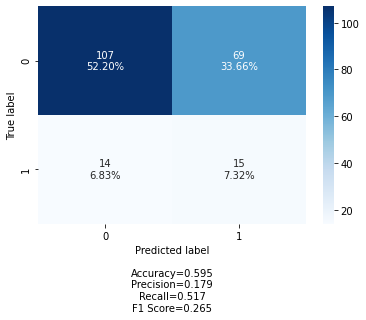

In [82]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

### Refined Architecture

In [377]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import precision_score, fbeta_score, f1_score, accuracy_score
from torch_geometric.data import DataLoader

In [382]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNStack, self).__init__()
        self.curr_dim = hidden_dim
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, self.curr_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(self.curr_dim))
        for l in range(2):
            old_dim = self.curr_dim
            self.curr_dim = old_dim // 2
            self.convs.append(self.build_conv_model(old_dim, self.curr_dim))
            self.lns.append(nn.LayerNorm(self.curr_dim))
        # post-message-passing (optional)
        self.post_mp = nn.Sequential(
            nn.Linear(self.curr_dim, self.curr_dim), nn.Dropout(0.25), 
            nn.Linear(self.curr_dim, output_dim))

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        return GCNConv(input_dim, hidden_dim)
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, edge_weight)
#             emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1: # linear xform
                x = self.lns[i](x)

        x = self.post_mp(x)
        return F.log_softmax(x, dim=1)

    def loss(self, weight, pred, label):
#         return F.nll_loss(input=pred, target=label)
        return F.nll_loss(weight=weight, input=pred, target=label)

### Early stopping

In [433]:
class LRScheduler():
    """
    Learning rate scheduler. If the validation loss does not decrease for the 
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
        self, optimizer, patience=50, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, fbeta_score):
        self.lr_scheduler.step(fbeta_score)

In [485]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=50, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = model
            
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = model
            self.counter = 0
        elif self.best_loss - val_loss <= self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [486]:
def train(data, writer):
    test_loader = loader = DataLoader(data, batch_size=32, shuffle=True)
    
    model = GNNStack(max(data.num_node_features, 1), 32, data.num_classes).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    lr_scheduler = LRScheduler(opt)
    early_stopping = EarlyStopping()
    for epoch in range(1000):
        total_loss = 0
        model.train()
        for batch in loader:
            batch.to(device)
            opt.zero_grad()
            out = model(batch)
            out = out[batch.train_mask]
            label = batch.y
            label = label[batch.train_mask]
            
            num_cheats = sum(label > 0)
            label_ratio = [len(label) - num_cheats, num_cheats]
            normWeights = [1 - (x/sum(label_ratio)) for x in label_ratio]
            normWeights = torch.FloatTensor(normWeights).to(device)
            
            loss = model.loss(weight=normWeights, pred=out, label=label)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)
        
        
        test_loss, test_acc, test_f1 = test(test_loader, model, is_validation=True)
#         if epoch % 50 == 0:
#             print("Epoch {}. Train Loss: {:.4f}. Test Loss: {:.4f}. Test F1: {:.4f}".format(epoch, total_loss, test_loss, test_f1))
        writer.add_scalar("test_loss", test_loss, epoch)
        writer.add_scalar("test_F0.5", test_f1, epoch)
        
        lr_scheduler(test_f1)   
        early_stopping(model, test_loss)
        
        if early_stopping.early_stop:
#             print("Stopped due to early stopping")
            print(early_stopping.best_loss)
            break # break out epochs training
            
    return early_stopping.best_model
            

In [487]:
def test(loader, model, is_validation=False):
    model.eval()
    correct = 0
    
    for batch in loader:
        val_loss = 0
        with torch.no_grad():
            batch.to(device)
            pred = model(batch)

            mask = batch.val_mask if is_validation else batch.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = batch.y
            label = label[mask]
            
    
            num_cheats = sum(label > 0)
            label_ratio = [len(label) - num_cheats, num_cheats]
            normWeights = [1 - (x/sum(label_ratio)) for x in label_ratio]
            normWeights = torch.FloatTensor(normWeights).to(device)
            
            loss = model.loss(weight=normWeights, pred=pred, label=label)
            val_loss += loss.item()
        
        pred = pred.cpu().argmax(dim=1)   
        label = label.cpu()
        correct += accuracy_score(pred, label, normalize=False)
        total = 0
        for data in loader.dataset:
            total += torch.sum(mask).item()
            
    return val_loss, (correct/total), f1_score(pred, label)

In [488]:
writer = SummaryWriter("runs/gnn_uniq_" + datetime.now().strftime("%Y%m%d-%H%M%S"))
writer_max = SummaryWriter("runs/gnn_max_" + datetime.now().strftime("%Y%m%d-%H%M%S"))
writer_min = SummaryWriter("runs/gnn_min_" + datetime.now().strftime("%Y%m%d-%H%M%S"))
writer_avg = SummaryWriter("runs/gnn_avg_" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [489]:
print("===================== Training with uniq line edges =====================")
best_model_uniq = train(bbc_data_uniq, writer)
print("===================== Training with max line edges =====================")
best_model_max = train(bbc_data_max, writer_max)
print("===================== Training with min line edges =====================")
best_model_min = train(bbc_data_min, writer_min)
print("===================== Training with avg line edges =====================")
best_model_avg = train(bbc_data_avg, writer_avg)

===================== Training with uniq line edges =====================
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50
INFO: Early stopping counter 6 of 50
INFO: Early stopping counter 7 of 50
INFO: Early stopping counter 8 of 50
INFO: Early stopping counter 9 of 50
INFO: Early stopping counter 10 of 50
INFO: Early stopping counter 11 of 50
INFO: Early stopping counter 12 of 50
INFO: Early stopping counter 13 of 50
INFO: Early stopping counter 14 of 50
INFO: Early stopping counter 15 of 50
INFO: Early stopping counter 16 of 50
INFO: Early stopping counter 17 of 50
INFO: Early stopping counter 18 of 50
INFO: Early stopping counter 19 of 50
INFO: Early stopping counter 20 of 50
INFO: Early stopping counter 21 of 50
INFO: Early stopping counter 22 of 50
INFO: Early stopping counter 23 of 50
INFO: Early stopping counter 24 of 50
INFO: Early stopping co

### Best uniq lines model:

In [490]:
torch.save(best_model_uniq.state_dict(), 'GNN/model_uniq_weights.pth')

In [491]:
torch.save(best_model_max.state_dict(), 'GNN/model_max_weights.pth')
torch.save(best_model_min.state_dict(), 'GNN/model_min_weights.pth')
torch.save(best_model_avg.state_dict(), 'GNN/model_avg_weights.pth')

In [492]:
best_model_uniq = GNNStack(max(bbc_data_uniq.num_node_features, 1), 32, bbc_data_uniq.num_classes)
best_model_max = GNNStack(max(bbc_data_max.num_node_features, 1), 32, bbc_data_max.num_classes)
best_model_min = GNNStack(max(bbc_data_min.num_node_features, 1), 32, bbc_data_min.num_classes)
best_model_avg = GNNStack(max(bbc_data_avg.num_node_features, 1), 32, bbc_data_avg.num_classes)

best_model_uniq.load_state_dict(torch.load('GNN/model_uniq_weights.pth'))
best_model_max.load_state_dict(torch.load('GNN/model_max_weights.pth'))
best_model_min.load_state_dict(torch.load('GNN/model_min_weights.pth'))
best_model_avg.load_state_dict(torch.load('GNN/model_avg_weights.pth'))

<All keys matched successfully>

In [493]:
def get_test_probas(model, data):
    with torch.no_grad():
        pred = model(data)
        mask = data.test_mask
        pred = pred[mask]
        label = data.y
        label = label[mask]
        return torch.exp(pred), label

In [494]:
uniq_probas, uniq_labels = get_test_probas(best_model_uniq, bbc_data_uniq[0])
max_probas, max_labels = get_test_probas(best_model_max, bbc_data_max[0])
min_probas, min_labels = get_test_probas(best_model_min, bbc_data_min[0])
avg_probas, avg_labels = get_test_probas(best_model_avg, bbc_data_avg[0])

Results using unique lines:


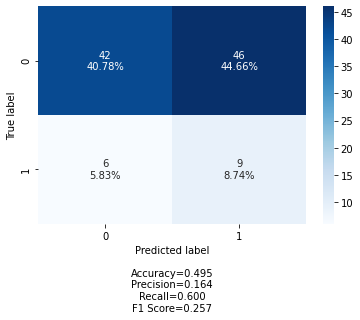


Precision @ 5: 0.4
Precision @ 10: 0.4
Precision @ 15: 0.26666666666666666


In [495]:
print("Results using unique lines:")
parse_results(proba=uniq_probas[:,1], true_labels=uniq_labels)

Results using max edges:


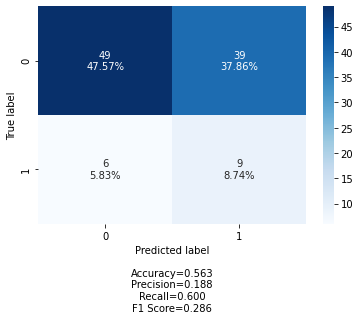


Precision @ 5: 0.6
Precision @ 10: 0.5
Precision @ 15: 0.3333333333333333


In [496]:
print("Results using max edges:")
parse_results(proba=max_probas[:,1], true_labels=max_labels)

Results using min edges:


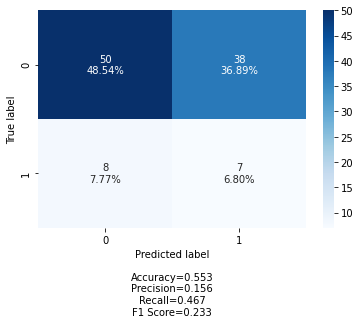


Precision @ 5: 0.2
Precision @ 10: 0.1
Precision @ 15: 0.13333333333333333


In [497]:
print("Results using min edges:")
parse_results(proba=min_probas[:,1], true_labels=min_labels)

Results using average edges:


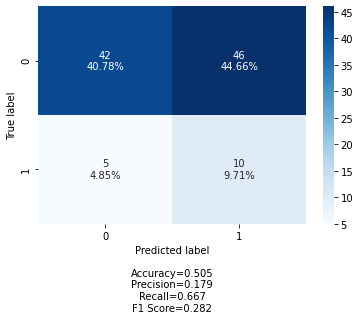


Precision @ 5: 0.0
Precision @ 10: 0.1
Precision @ 15: 0.13333333333333333


In [498]:
print("Results using average edges:")
parse_results(proba=avg_probas[:,1], true_labels=avg_labels)

In [ ]:
# check tensorboard.

# try different hidden dimensions
# standardising edge weights.
# trying different optimizing schedules, learning rate scheduler, 
# early stopping.
# Try GraphConv, and other layers, pass edge_weights
# different layernorm, different dropouts
# should add lin layers?
